# Tuning LoRA Hyperparameters - Identifying Baselines and Initial Hyperparameters

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append('src')

import sagemaker
from sagemaker.pytorch import PyTorch

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters,
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results
)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:util:Total parameters: 124,647,170, thereof learnable: 124,647,170 (100.0000%)


## Establishing Baseline Performance and Hyperparameters
Before we run any experiment with LoRA itself, let's establish a performance baseline. 

This includes finding good hyperparameters. We'll just tune learning rate and orient ourselves with weight decay and dropout on the values used in the RoBERTa and LoRA papers. Keeping these hyperparameters fixed it will isolate the impact of the architectural changes (which components to adopt, what size of the components) and hence makes it easier to follow.
We are maintaining this approach through all notebooks. But if you are replicating this approach for your task and model, consider using the best found hyperparameter values, but then also tune for weight decay and dropout. This could be helpful to get the last bit of performance and to control variance.

Back to the baselines. We could capture data for three scenarios: 
- Random Performance (not captured, not interesting enough) 
- Training of the classifier head only, using the RoBERTa layers only in a feature-extractor-fashion (expectation: lower bound of performance)
- Full finetuning (expectation: higher bound of performance)

An an side, let's find out how many parameters we have in a model, **before** we add trainable parameters for LoRA. This way we find the true 100%. Later in these notebooks we use this information to calculate how many parameters we need to train for LoRA, relative to those 100% of the original model. 

In [3]:
from transformers import AutoModelForSequenceClassification

roberta_total, roberta_learnable = count_parameters(
    AutoModelForSequenceClassification.from_pretrained('roberta-base'), 
    verbose=False
)
roberta_learnable, roberta_total

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:src.util:Total parameters: 124,647,170, thereof learnable: 124,647,170 (100.0000%)


(124647170, 124647170)

### Full-Finetuning Performance
#### Initial Search

In [4]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner, HyperbandStrategyConfig, StrategyConfig, TuningJobCompletionCriteriaConfig

In [5]:
fullft_estimator = PyTorch(**get_default_estimator_parameters())
fullft_estimator.set_hyperparameters(**{'sst2-lora-config': 'none'})

hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(1e-5, 6e-5),
    'sst2-epochs': IntegerParameter(8, 17), 
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Bayesian',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = fullft_estimator,
    base_tuning_job_name = 'full-finetuning',
    max_jobs = 30,
    max_parallel_jobs = 3,
    completion_criteria_config=TuningJobCompletionCriteriaConfig(complete_on_convergence=True)
))}

lr_tuner = HyperparameterTuner(**tuner_parameters)
lr_tuner.fit(wait=False)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: full-finetuning-231209-0038


In [6]:
clf_estimator = PyTorch(**get_default_estimator_parameters())
clf_estimator.set_hyperparameters(**{'sst2-lora-config': 'clf_only'})

hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(8e-4, 2e-2), 
    'sst2-epochs': IntegerParameter(10, 17), 
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Bayesian',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = clf_estimator,
    base_tuning_job_name = 'clf-only-tuning',
    max_jobs = 30,
    max_parallel_jobs = 3,
    completion_criteria_config=TuningJobCompletionCriteriaConfig(complete_on_convergence=True)
))}
lr_clf_tuner = HyperparameterTuner(**tuner_parameters)
lr_clf_tuner.fit(wait=False)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: clf-only-tuning-231209-0038


### Find Initial Hyperparameters for LoRA Finetuning
We don't want to vary too many hyperparameters at the same time. Hence we fix the learning rate and weight decay (from the base config). But as both hyperparameters can be significantly different for the low parameters learning regime with LoRA vs the high pararameters regime with a full finetuning, we will tune for some setting in the low parameters regime. And, maybe, at the end we could tune again with learning rate and weight decay again

In [7]:
lora_base_estimator = PyTorch(**get_default_estimator_parameters())
lora_base_estimator.set_hyperparameters(**{'sst2-lora-r': 8, 'sst2-lora-config': 'all', }) 
hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(2e-4, 5e-3), 
    'sst2-epochs': IntegerParameter(9, 20),  
}

max_jobs = 30
tuner_parameters = {**(p('tuner_parameters') | dict(
    metric_definitions=p('metric_definitions'),
    base_tuning_job_name= 'lora-base-tuning', 
    max_jobs=max_jobs,   
    strategy= 'Bayesian',
    hyperparameter_ranges= hpt_ranges,
    max_parallel_jobs=3,
    estimator=lora_base_estimator))}

base_lora_tuner = HyperparameterTuner(**tuner_parameters)
base_lora_tuner.fit(wait=False)
base_lora_tuner_name = base_lora_tuner.describe()["HyperParameterTuningJobName"]
%store base_lora_tuner_name

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: lora-base-tuning-231209-0038
Stored 'base_lora_tuner_name' (str)


### Analysis

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

'full-finetuning-231209-0038'

Tuning job full-finetuning-231209-0038 status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 30
Lowest: 0.9323394298553467 Highest 0.9529816508293152


,sst2-epochs,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,10.0,0.000030,full-finetuning-231209-0038-029-16214708,Completed,2023-12-09 04:02:23+01:00,2023-12-09 04:20:24+01:00,1081.0,full-finetuning-231209-0038,0.952982
17,9.0,0.000045,full-finetuning-231209-0038-013-cb0449a5,Completed,2023-12-09 02:02:17+01:00,2023-12-09 02:19:07+01:00,1010.0,full-finetuning-231209-0038,0.950688
4,15.0,0.000028,full-finetuning-231209-0038-026-9a4b4226,Completed,2023-12-09 03:36:09+01:00,2023-12-09 04:00:31+01:00,1462.0,full-finetuning-231209-0038,0.949541
0,12.0,0.000028,full-finetuning-231209-0038-030-e3f8ed4d,Completed,2023-12-09 04:12:52+01:00,2023-12-09 04:33:23+01:00,1231.0,full-finetuning-231209-0038,0.948394
27,9.0,0.000045,full-finetuning-231209-0038-003-a05c3305,Completed,2023-12-09 00:39:18+01:00,2023-12-09 00:56:04+01:00,1006.0,full-finetuning-231209-0038,0.948394
6,10.0,0.000029,full-finetuning-231209-0038-024-028f26b7,Completed,2023-12-09 03:25:28+01:00,2023-12-09 03:43:28+01:00,1080.0,full-finetuning-231209-0038,0.947248
9,17.0,0.000028,full-finetuning-231209-0038-021-48d5b67d,Completed,2023-12-09 02:55:19+01:00,2023-12-09 03:22:02+01:00,1603.0,full-finetuning-231209-0038,0.947248
12,9.0,0.000045,full-finetuning-231209-0038-018-07f1f2b6,Completed,2023-12-09 02:35:56+01:00,2023-12-09 02:52:42+01:00,1006.0,full-finetuning-231209-0038,0.946101
24,10.0,0.000045,full-finetuning-231209-0038-006-0214dcc7,Completed,2023-12-09 01:02:12+01:00,2023-12-09 01:20:13+01:00,1081.0,full-finetuning-231209-0038,0.946101
13,15.0,0.000045,full-finetuning-231209-0038-017-c5a7f809,Completed,2023-12-09 02:21:18+01:00,2023-12-09 02:45:28+01:00,1450.0,full-finetuning-231209-0038,0.946101


Cache Hit/Miss: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


WARN shape dropped as it is incompatible with "bar".
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


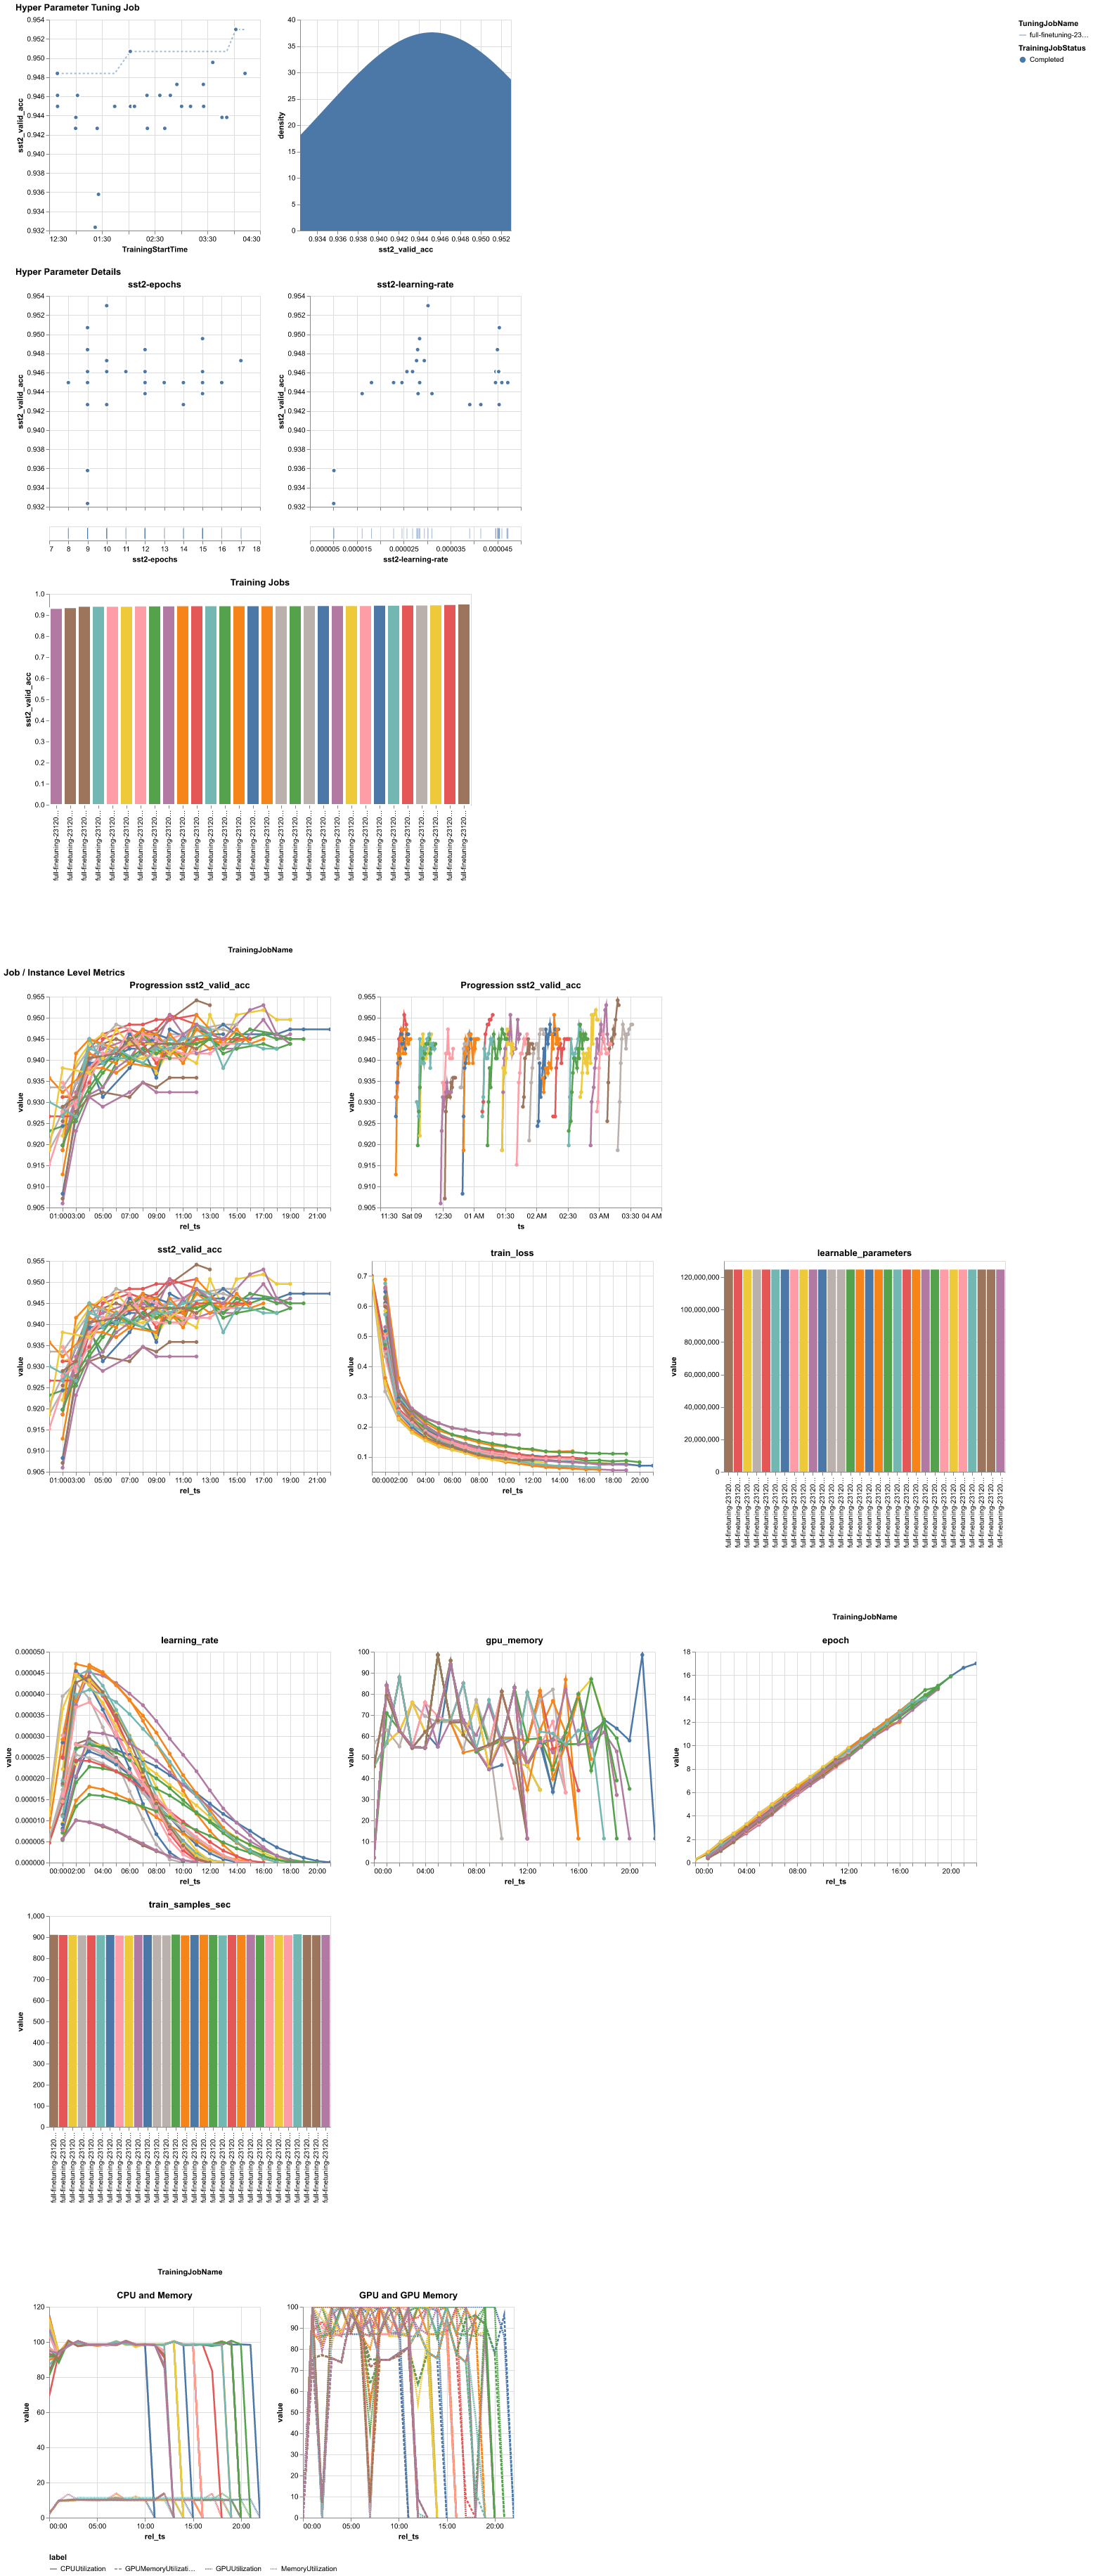

!


'clf-only-tuning-231209-0038'

Tuning job clf-only-tuning-231209-0038 status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 30
Lowest: 0.8142201900482178 Highest 0.8279816508293152


,sst2-epochs,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
4,15.0,0.006144,clf-only-tuning-231209-0038-026-8f83f79d,Completed,2023-12-09 02:37:22+01:00,2023-12-09 02:50:31+01:00,789.0,clf-only-tuning-231209-0038,0.827982
14,15.0,0.011187,clf-only-tuning-231209-0038-016-0cc40194,Completed,2023-12-09 01:53:05+01:00,2023-12-09 02:06:14+01:00,789.0,clf-only-tuning-231209-0038,0.825688
19,15.0,0.004941,clf-only-tuning-231209-0038-011-c3a39b39,Completed,2023-12-09 01:22:14+01:00,2023-12-09 01:35:23+01:00,789.0,clf-only-tuning-231209-0038,0.825688
12,15.0,0.005347,clf-only-tuning-231209-0038-018-9c38cb46,Completed,2023-12-09 01:52:45+01:00,2023-12-09 02:05:49+01:00,784.0,clf-only-tuning-231209-0038,0.825688
8,15.0,0.011606,clf-only-tuning-231209-0038-022-16fadc2c,Completed,2023-12-09 02:22:44+01:00,2023-12-09 02:35:54+01:00,790.0,clf-only-tuning-231209-0038,0.824541
22,13.0,0.005874,clf-only-tuning-231209-0038-008-81ed3f5e,Completed,2023-12-09 01:08:15+01:00,2023-12-09 01:20:30+01:00,735.0,clf-only-tuning-231209-0038,0.824541
11,15.0,0.006249,clf-only-tuning-231209-0038-019-6deefbeb,Completed,2023-12-09 02:07:43+01:00,2023-12-09 02:20:53+01:00,790.0,clf-only-tuning-231209-0038,0.824541
9,15.0,0.007130,clf-only-tuning-231209-0038-021-4f7a2e1a,Completed,2023-12-09 02:07:53+01:00,2023-12-09 02:21:02+01:00,789.0,clf-only-tuning-231209-0038,0.824541
27,13.0,0.004537,clf-only-tuning-231209-0038-003-ee9543d8,Completed,2023-12-09 00:39:24+01:00,2023-12-09 00:51:38+01:00,734.0,clf-only-tuning-231209-0038,0.824541
6,15.0,0.011398,clf-only-tuning-231209-0038-024-6b16c5b8,Completed,2023-12-09 02:22:42+01:00,2023-12-09 02:35:56+01:00,794.0,clf-only-tuning-231209-0038,0.824541


Cache Hit/Miss: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


WARN shape dropped as it is incompatible with "bar".


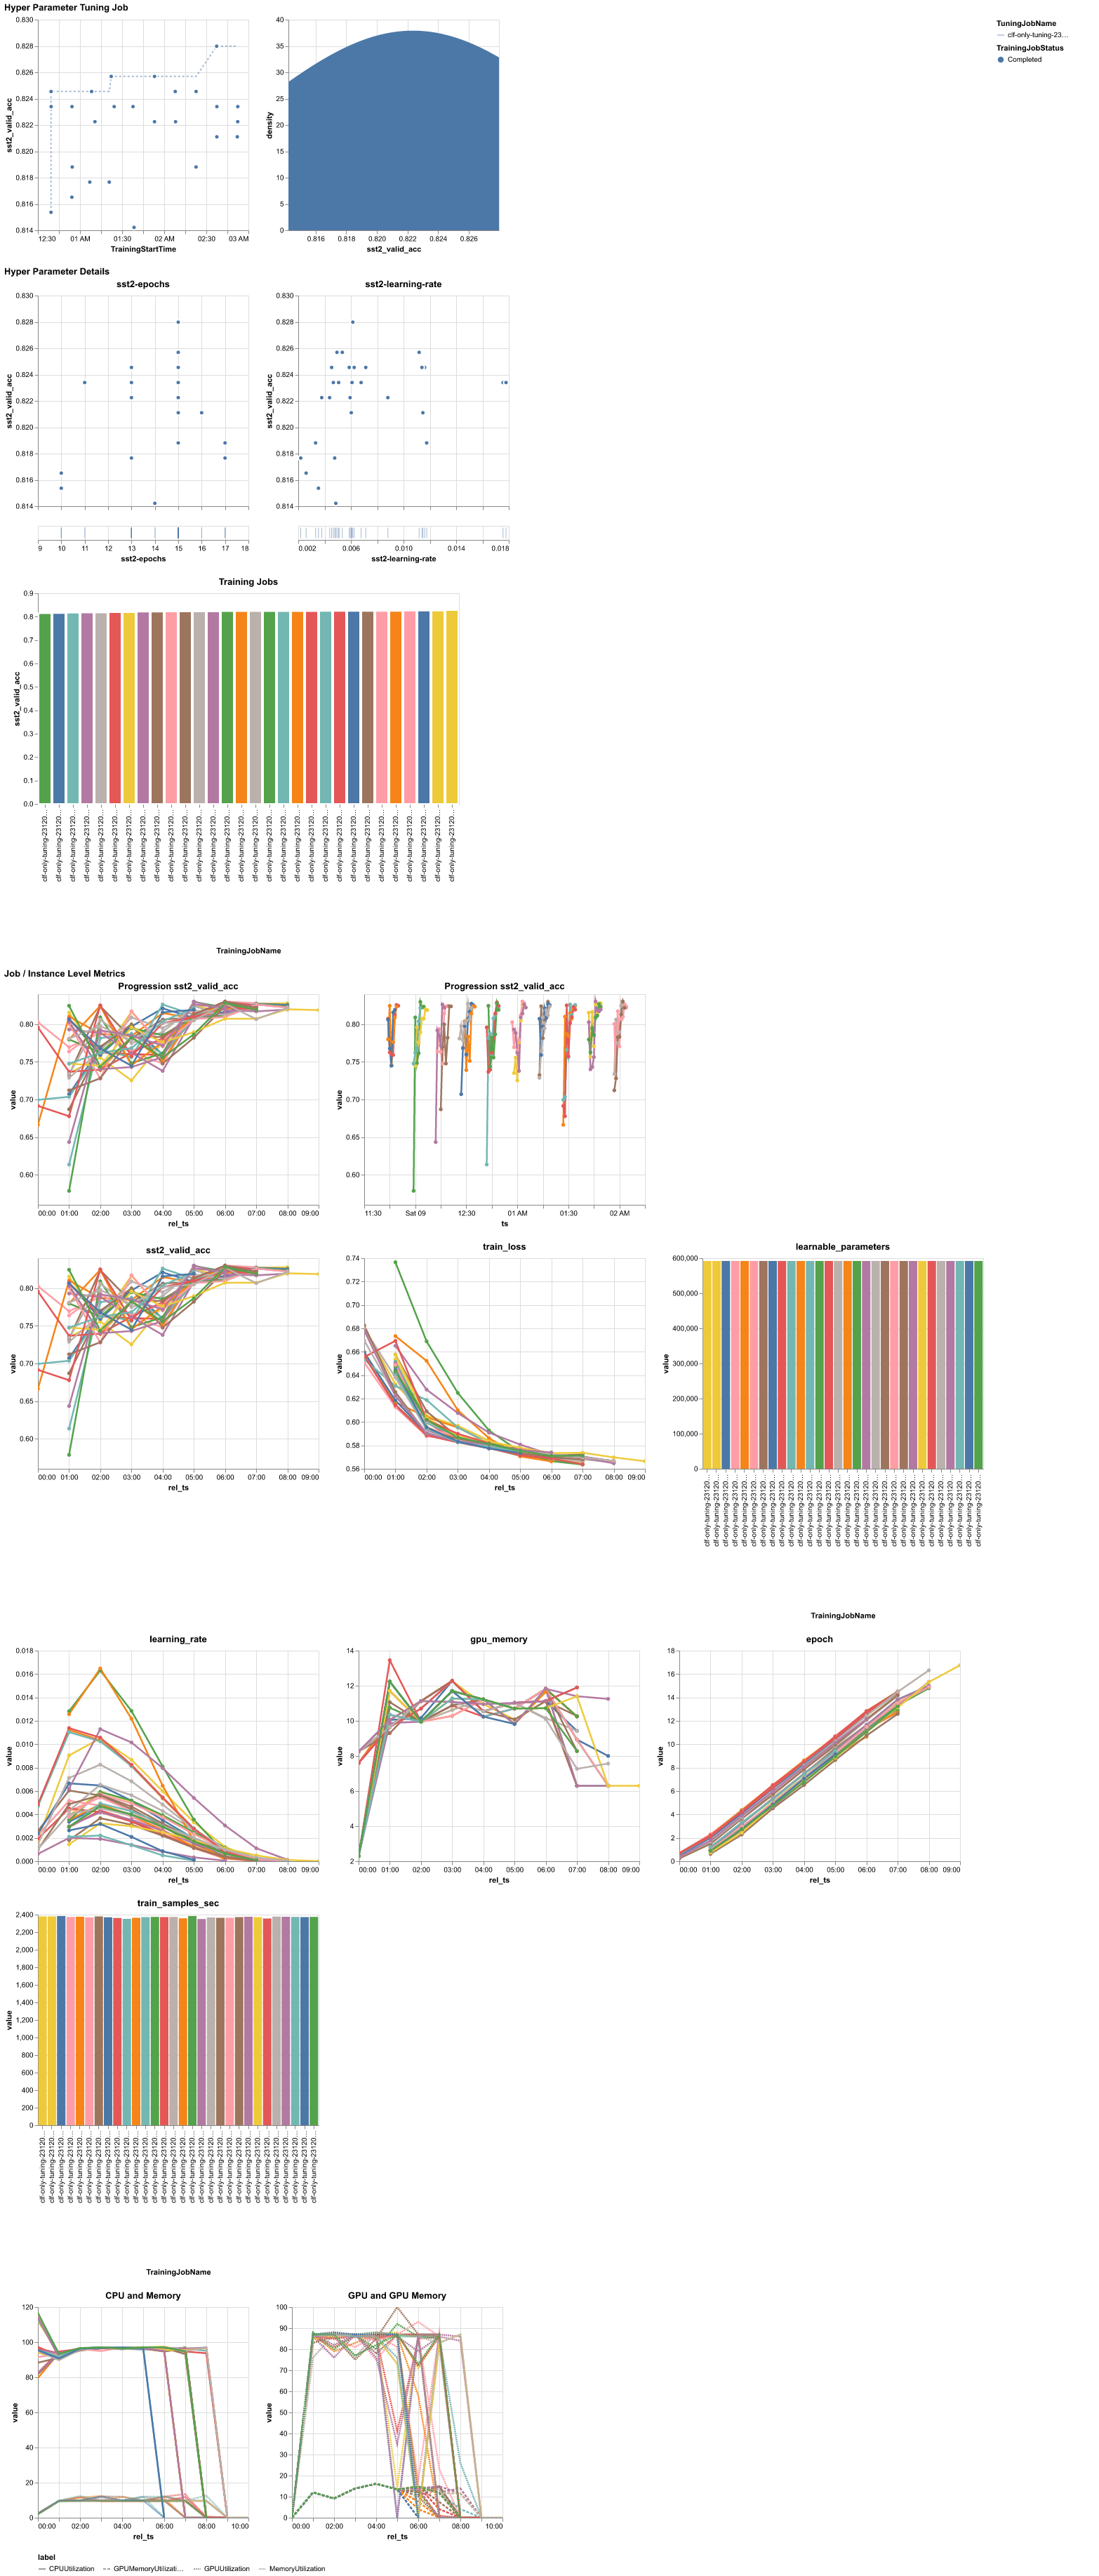

WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


'lora-base-tuning-231209-0038'

Tuning job lora-base-tuning-231209-0038 status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 30
Lowest: 0.9277523159980774 Highest 0.9506880640983582


,sst2-epochs,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
8,14.0,0.001447,lora-base-tuning-231209-0038-022-8da46acb,Completed,2023-12-09 04:07:10+01:00,2023-12-09 04:33:27+01:00,1577.0,lora-base-tuning-231209-0038,0.950688
5,14.0,0.001501,lora-base-tuning-231209-0038-025-7fb67a5e,Completed,2023-12-09 04:35:10+01:00,2023-12-09 05:01:27+01:00,1577.0,lora-base-tuning-231209-0038,0.948394
3,14.0,0.001649,lora-base-tuning-231209-0038-027-93454305,Completed,2023-12-09 04:42:53+01:00,2023-12-09 05:09:11+01:00,1578.0,lora-base-tuning-231209-0038,0.947248
6,14.0,0.001833,lora-base-tuning-231209-0038-024-46d7089b,Completed,2023-12-09 04:13:57+01:00,2023-12-09 04:40:09+01:00,1572.0,lora-base-tuning-231209-0038,0.947248
23,14.0,0.001415,lora-base-tuning-231209-0038-007-0a3dcc24,Completed,2023-12-09 01:41:19+01:00,2023-12-09 02:07:41+01:00,1582.0,lora-base-tuning-231209-0038,0.947248
2,14.0,0.001563,lora-base-tuning-231209-0038-028-ebe6c32e,Completed,2023-12-09 05:03:27+01:00,2023-12-09 05:29:45+01:00,1578.0,lora-base-tuning-231209-0038,0.946101
7,14.0,0.001639,lora-base-tuning-231209-0038-023-ebabef83,Completed,2023-12-09 04:07:06+01:00,2023-12-09 04:33:23+01:00,1577.0,lora-base-tuning-231209-0038,0.946101
21,13.0,0.002147,lora-base-tuning-231209-0038-009-6f472417,Completed,2023-12-09 01:47:54+01:00,2023-12-09 02:12:41+01:00,1487.0,lora-base-tuning-231209-0038,0.946101
15,20.0,0.001354,lora-base-tuning-231209-0038-015-aacdfa10,Completed,2023-12-09 02:46:37+01:00,2023-12-09 03:21:36+01:00,2099.0,lora-base-tuning-231209-0038,0.944954
17,16.0,0.001410,lora-base-tuning-231209-0038-013-1834eb1f,Completed,2023-12-09 02:44:03+01:00,2023-12-09 03:13:11+01:00,1748.0,lora-base-tuning-231209-0038,0.944954


Cache Hit/Miss: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


WARN shape dropped as it is incompatible with "bar".
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


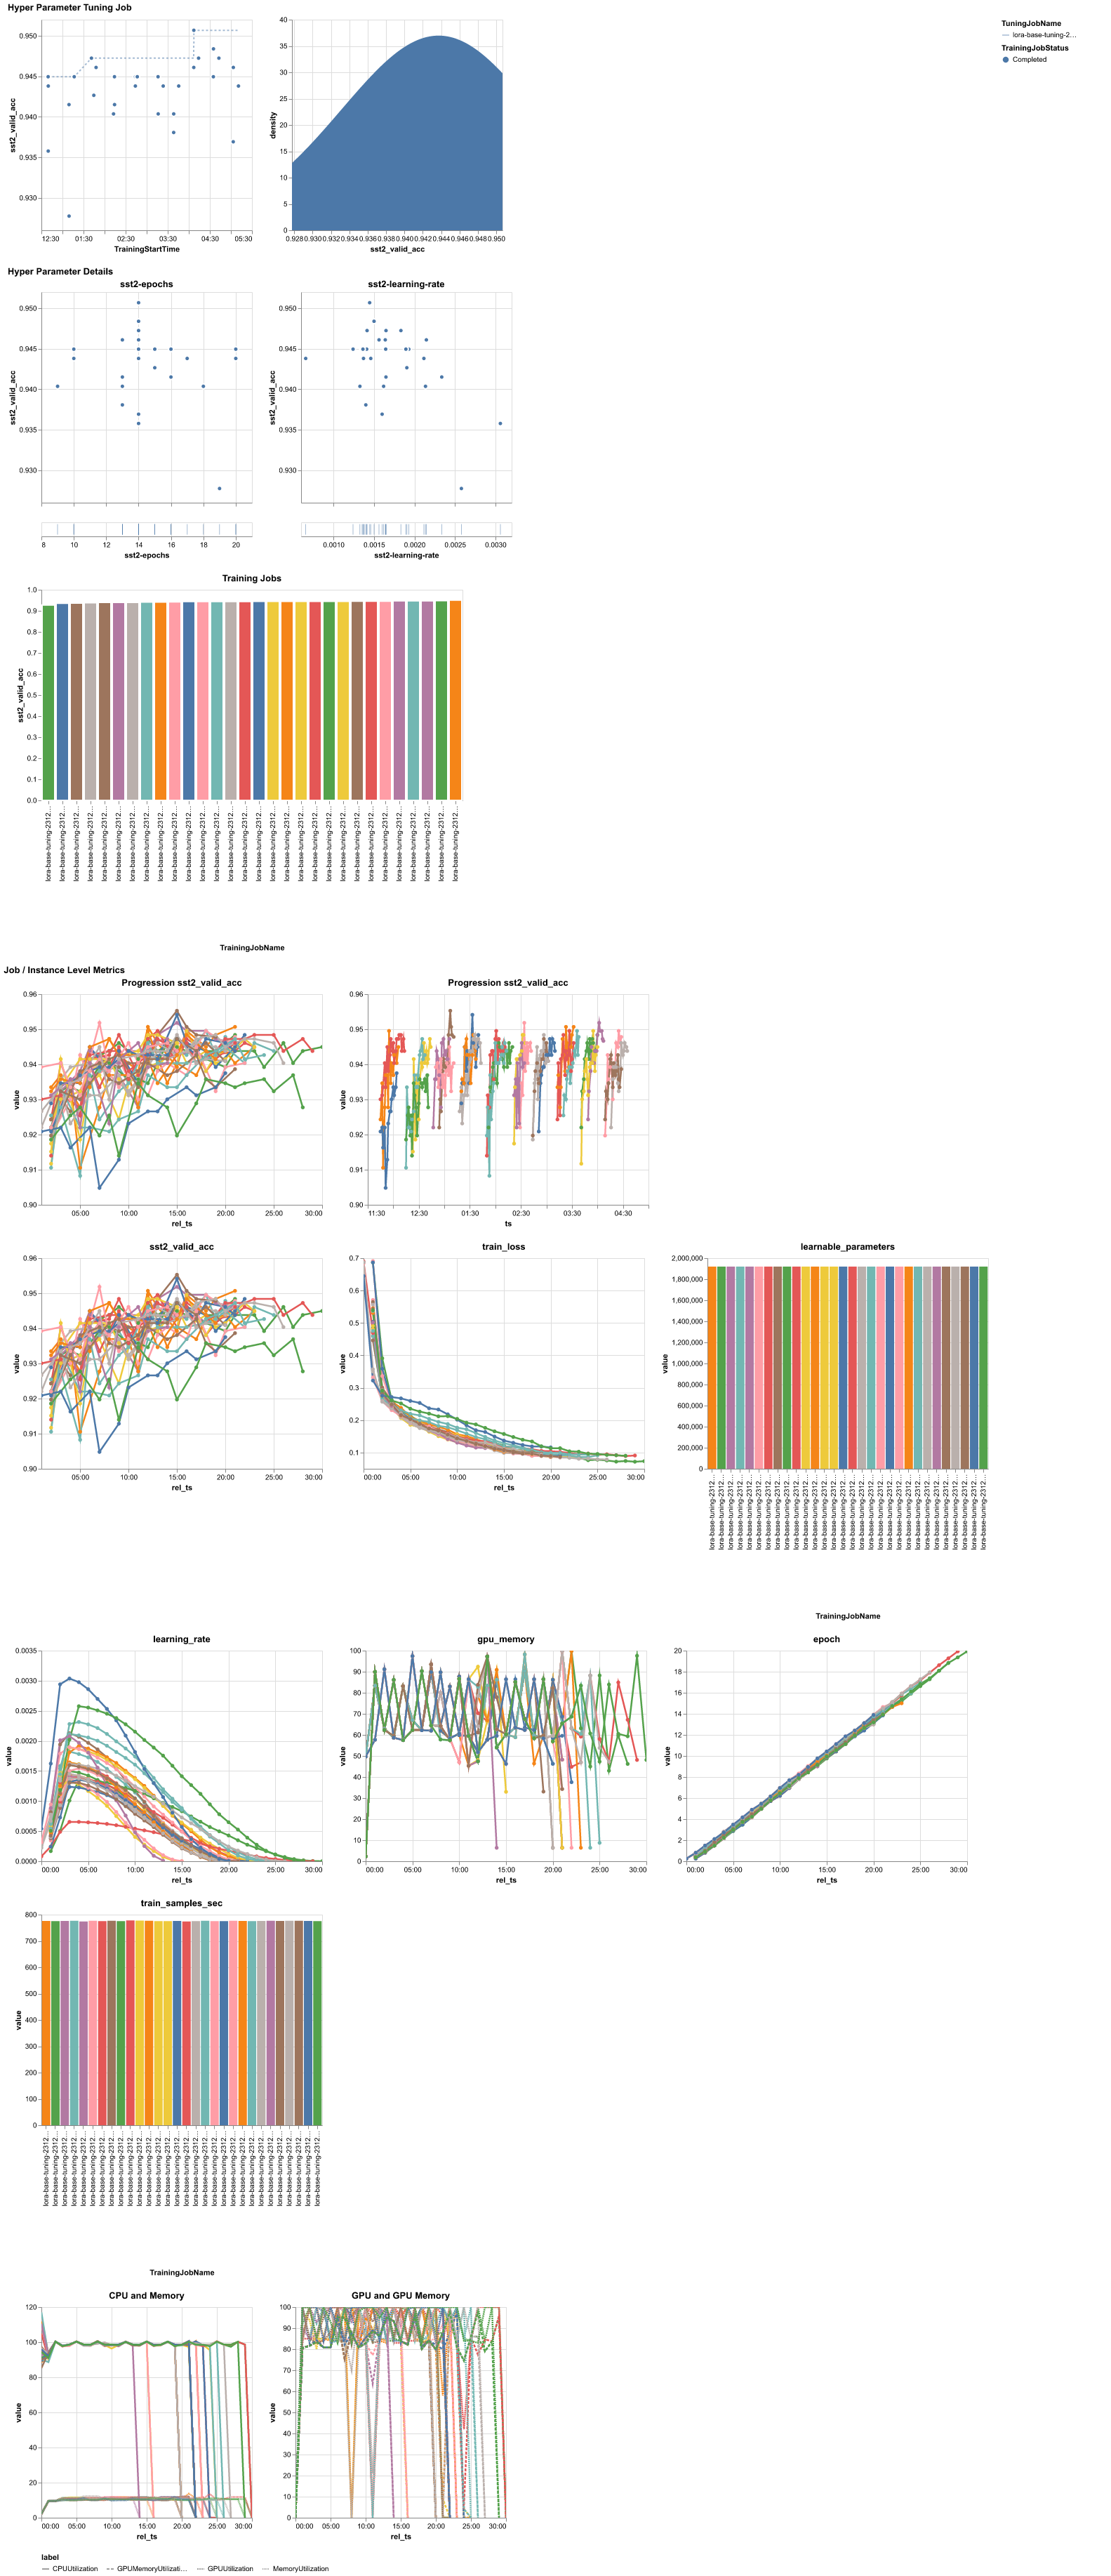

In [8]:
display_tuning_jobs([lr_tuner, lr_clf_tuner, base_lora_tuner])

So far so good. But now we don't want to find the best hyperparameter values, but want to sample certain combinations of hyperparameter values to judge their impact. While above we used Bayesian Optimization to search for hyperparameters, which takes the results from earlier trials to inform which hyperparameter values to pick for new trials. 
Below we want to capture the impact of the hyperparameter values we found for our scenarios and want to estimate how noisy these combinations are. 

#### Capture Results

In [9]:
capture_results('Full Finetuning', fullft_estimator, lr_tuner) 

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-231209-0539
....................................................................................................................................................................................................................................................!
Tuning job capture-231209-0539       status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training j

,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
4,0.0,capture-231209-0539-001-23b115a6,Completed,2023-12-09 05:40:52+01:00,2023-12-09 05:58:52+01:00,1080.0,capture-231209-0539,0.948394
1,4.0,capture-231209-0539-004-169b75b0,Completed,2023-12-09 05:41:17+01:00,2023-12-09 05:59:23+01:00,1086.0,capture-231209-0539,0.947248
2,3.0,capture-231209-0539-003-edf8455e,Completed,2023-12-09 05:41:04+01:00,2023-12-09 05:59:05+01:00,1081.0,capture-231209-0539,0.946101
0,5.0,capture-231209-0539-005-9940df28,Completed,2023-12-09 05:41:22+01:00,2023-12-09 05:59:33+01:00,1091.0,capture-231209-0539,0.944954
3,2.0,capture-231209-0539-002-a5b52965,Completed,2023-12-09 05:40:56+01:00,2023-12-09 05:58:57+01:00,1081.0,capture-231209-0539,0.942661


Cache Hit/Miss: MMMMM


In [10]:
capture_results('Classifier Only', clf_estimator, lr_clf_tuner) 

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-231209-0600
..........................................................................................................................................................................................................!
Tuning job capture-231209-0600       status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 5
Lowest: 0.8233

,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
3,2.0,capture-231209-0600-002-aeaed121,Completed,2023-12-09 06:02:08+01:00,2023-12-09 06:15:17+01:00,789.0,capture-231209-0600,0.826835
4,0.0,capture-231209-0600-001-f6cc64b9,Completed,2023-12-09 06:02:42+01:00,2023-12-09 06:15:50+01:00,788.0,capture-231209-0600,0.824541
0,5.0,capture-231209-0600-005-8c9b2406,Completed,2023-12-09 06:02:08+01:00,2023-12-09 06:15:22+01:00,794.0,capture-231209-0600,0.823394
1,4.0,capture-231209-0600-004-51c12233,Completed,2023-12-09 06:02:08+01:00,2023-12-09 06:15:17+01:00,789.0,capture-231209-0600,0.823394
2,3.0,capture-231209-0600-003-26aab2c4,Completed,2023-12-09 06:02:22+01:00,2023-12-09 06:15:31+01:00,789.0,capture-231209-0600,0.823394


Cache Hit/Miss: MMMMM


In [11]:
capture_results('LoRA Base', lora_base_estimator, base_lora_tuner) 

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-231209-0618
...........................................................................................................................................................................................................................................................................................................................................................!
Tuning job capture-231209-0618       status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying S

,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,5.0,capture-231209-0618-005-9f4aff70,Completed,2023-12-09 06:19:58+01:00,2023-12-09 06:46:11+01:00,1573.0,capture-231209-0618,0.950688
2,3.0,capture-231209-0618-003-3cbf7a84,Completed,2023-12-09 06:20:31+01:00,2023-12-09 06:46:49+01:00,1578.0,capture-231209-0618,0.946101
1,4.0,capture-231209-0618-004-754a7c0d,Completed,2023-12-09 06:20:00+01:00,2023-12-09 06:46:19+01:00,1579.0,capture-231209-0618,0.944954
3,2.0,capture-231209-0618-002-af893f5d,Completed,2023-12-09 06:19:58+01:00,2023-12-09 06:46:11+01:00,1573.0,capture-231209-0618,0.944954
4,0.0,capture-231209-0618-001-95cf39ca,Completed,2023-12-09 06:20:06+01:00,2023-12-09 06:46:24+01:00,1578.0,capture-231209-0618,0.943807


Cache Hit/Miss: MMMMM


,target_tuner_name,title,objective_metric_mean,objective_metric_std,parameters_relative,train_speed_median,gpu_memory_max
0,capture-231209-0539,Full Finetuning,0.945872,0.002206,100.000000,909.390,98.500
1,capture-231209-0600,Classifier Only,0.824312,0.001495,0.475045,2376.222,12.275
2,capture-231209-0618,LoRA Base,0.946101,0.002689,1.539733,777.052,97.400


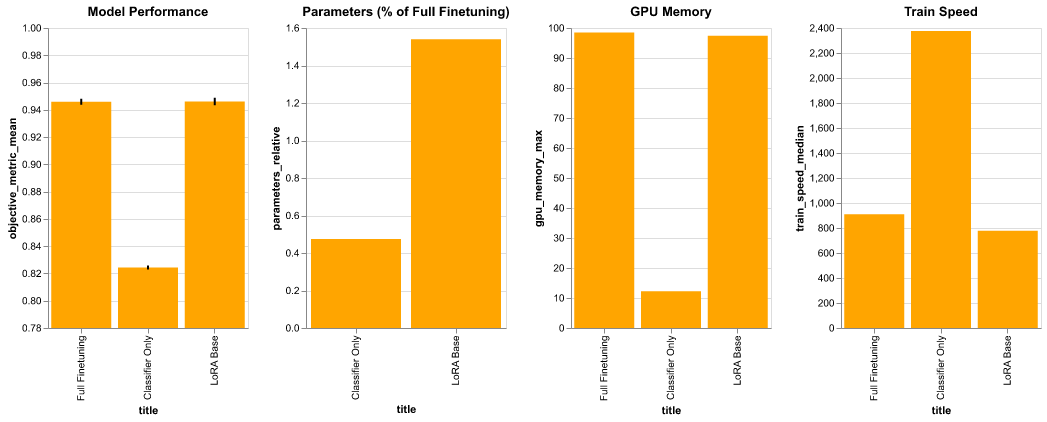

In [12]:
graph_results()